In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [160]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
plt.style.use("seaborn")

In [2]:
df = pd.read_excel("project data/EAI6010Project.xlsx", sheet_name="RiskZoneData")

## Loading Geospatial Massachusetts data:

In [3]:
USA_geo = gpd.read_file("project data/mass_zcta/cb_2019_us_zcta510_500k.shp")

In [4]:
USA_geo["ZCTA5CE10"] = USA_geo["ZCTA5CE10"].map(lambda x: int(x))

In [5]:
zips = df["ZipCode"]
MA_geo = USA_geo[USA_geo["ZCTA5CE10"].isin(zips)]

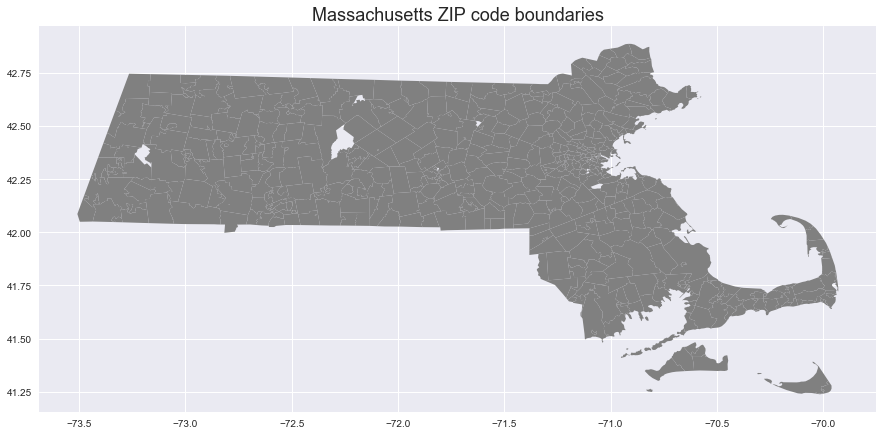

In [31]:
fig, ax = plt.subplots(1, figsize=(15, 15))
ma_plot = MA_geo.plot(ax=ax, color="gray")
plt.title("Massachusetts ZIP code boundaries", fontsize=18)
plt.show()

In [21]:
working_df = gpd.GeoDataFrame(pd.merge(left=df, right=MA_geo, left_on="ZipCode", right_on="ZCTA5CE10"))

## Blue Bikes data processing:

#### [Official open source data source](https://www.bluebikes.com/system-data)

In [10]:
bb_df = pd.read_csv("project data/202003-bluebikes-tripdata.csv")

In [11]:
bb_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,366,2020-03-01 00:01:09.0060,2020-03-01 00:07:15.2360,9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,446,700 Commonwealth Ave.,42.349609,-71.103915,5566,Customer,1969,0
1,367,2020-03-01 00:01:10.9500,2020-03-01 00:07:18.1970,9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,446,700 Commonwealth Ave.,42.349609,-71.103915,4113,Customer,1969,0
2,120,2020-03-01 00:01:50.3890,2020-03-01 00:03:51.3510,372,Boylston St at Exeter St,42.349589,-71.079468,16,Back Bay T Stop - Dartmouth St at Stuart St,42.348074,-71.076570,4854,Subscriber,1960,1
3,646,2020-03-01 00:01:57.2720,2020-03-01 00:12:43.5950,328,Grove St at Community Path,42.396387,-71.120113,115,Porter Square Station,42.387995,-71.119084,3441,Subscriber,1994,1
4,424,2020-03-01 00:02:03.9240,2020-03-01 00:09:08.3250,104,Harvard University Radcliffe Quadrangle at She...,42.380287,-71.125107,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,5497,Subscriber,1962,2


In [18]:
from functools import partial
from shapely import geometry

def get_point(row, lat_name, long_name):
    return geometry.Point(row[long_name], row[lat_name])

get_start = partial(get_point, lat_name="start station latitude", long_name="start station longitude")
get_end = partial(get_point, lat_name="end station latitude", long_name="end station longitude")

bb_df["start_station_point"] = bb_df.apply(get_start, axis=1)
bb_df["end_station_point"] = bb_df.apply(get_end, axis=1)

In [ ]:
def calculate_trips_for_poly(bb_row, zip_poly):
    start_trip = bb_row.start_station_point.within(zip_poly)
    end_trip = bb_row.end_station_point.within(zip_poly)
    return any([start_trip, end_trip])
    
def find_number_of_trips(zone_row):
    trips = bb_df.apply(lambda x: calculate_trips_for_poly(x, zone_row.geometry), axis=1).value_counts()
    try:
        return trips[1]
    except KeyError:
        return 0

    
working_df["number_of_bb_trips"] = working_df.apply(find_number_of_trips, axis=1)

In [ ]:
working_df[["ZipCode", "number_of_bb_trips"]].to_csv("project data/bb_trips.csv")

## Public transport data processing:
#### [Bus stops MBTA public available dataset](https://docs.digital.mass.gov/dataset/massgis-data-mbta-bus-routes-and-stops)
#### [Rapid Transit stops MBTA public available dataset](https://maps-massgis.opendata.arcgis.com/datasets/a9e4d01cbfae407fbf5afe67c5382fde_0)

### Bus stops data:

In [24]:
mbta = gpd.read_file("project data/mbtabus/MBTABUSSTOPS_PT.shp")
mbta = mbta.to_crs(epsg=4326)

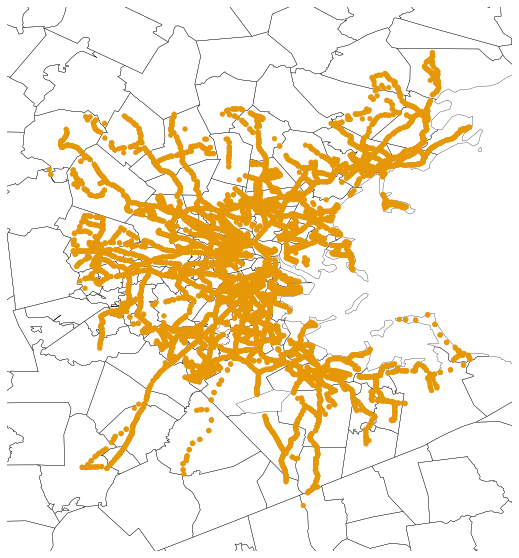

In [81]:
import geoplot


ax = geoplot.polyplot(MA_geo, figsize=(15, 10))
geoplot.pointplot(mbta, ax=ax, color="#e59706")
plt.show()

### Rapid transit stops data:

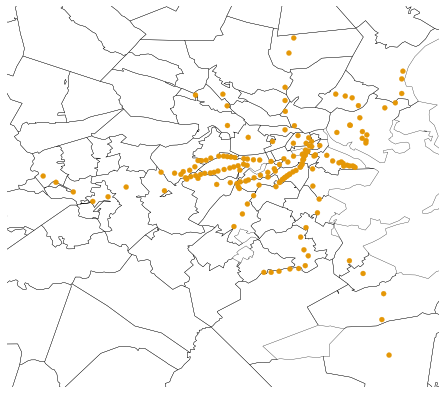

In [167]:
import geoplot


ax = geoplot.polyplot(MA_geo, figsize=(10, 7))
geoplot.pointplot(mbta_rapid_transit, ax=ax, color="#e59706")
plt.show()

In [82]:
mbta_rapid_transit = gpd.read_file("project data/mbta_rapid_transit/MBTA_NODE.shp")
mbta_rapid_transit = mbta_rapid_transit.to_crs(epsg=4326)

In [83]:
def stop_within_poly(bs_row, zip_poly):
    return bs_row.geometry.within(zip_poly)
    
    
def find_number_of_stops(zone_row, mbta_df):
    stops = mbta_df.apply(lambda x: stop_within_poly(x, zone_row.geometry), axis=1).value_counts()
    print(f"Counted for {zone_row.County} {zone_row.City} {zone_row.ZipCode}")
    try:
        n_stops =stops[1]
    except KeyError:
        n_stops = 0
        
    print(n_stops)
    return n_stops

working_df["number_of_bus_stops"] = working_df.apply(lambda x: find_number_of_stops(x, mbta), axis=1)
working_df["number_of_other_stops"] = working_df.apply(lambda x: find_number_of_stops(x, mbta_rapid_transit), axis=1)

Counted for Hampden Agawam 1001
0
Counted for Hampshire Amherst 1002
0
Counted for Hampshire Amherst 1003
0
Counted for Worcester Barre 1005
0
Counted for Hampshire Belchertown 1007
0
Counted for Hampden Blandford 1008
0
Counted for Hampden Bondsville 1009
0
Counted for Hampden Brimfield 1010
0
Counted for Hampden Chester 1011
0
Counted for Hampshire Chesterfield 1012
0
Counted for Hampden Chicopee 1013
0
Counted for Hampden Chicopee 1020
0
Counted for Hampden Chicopee 1022
0
Counted for Hampshire Cummington 1026
0
Counted for Hampshire Easthampton 1027
0
Counted for Hampden East Longmeadow 1028
0
Counted for Berkshire East Otis 1029
0
Counted for Hampden Feeding Hills 1030
0
Counted for Worcester Gilbertville 1031
0
Counted for Hampshire Goshen 1032
0
Counted for Hampshire Granby 1033
0
Counted for Hampden Granville 1034
0
Counted for Hampshire Hadley 1035
0
Counted for Hampden Hampden 1036
0
Counted for Worcester Hardwick 1037
0
Counted for Hampshire Hatfield 1038
0
Counted for Hamps

Counted for Worcester Worcester 1610
0
Counted for Worcester Cherry Valley 1611
0
Counted for Worcester Paxton 1612
0
Counted for Middlesex Framingham 1701
0
Counted for Middlesex Framingham 1702
0
Counted for Middlesex Village Of Nagog Woods 1718
0
Counted for Middlesex Boxborough 1719
0
Counted for Middlesex Acton 1720
0
Counted for Middlesex Ashland 1721
0
Counted for Middlesex Bedford 1730
59
Counted for Middlesex Hanscom Afb 1731
0
Counted for Worcester Bolton 1740
0
Counted for Middlesex Carlisle 1741
0
Counted for Middlesex Concord 1742
0
Counted for Worcester Fayville 1745
0
Counted for Middlesex Holliston 1746
0
Counted for Worcester Hopedale 1747
0
Counted for Middlesex Hopkinton 1748
0
Counted for Middlesex Hudson 1749
0
Counted for Middlesex Marlborough 1752
0
Counted for Middlesex Maynard 1754
0
Counted for Worcester Mendon 1756
0
Counted for Worcester Milford 1757
0
Counted for Middlesex Natick 1760
0
Counted for Middlesex Sherborn 1770
0
Counted for Worcester Southboroug

Counted for Middlesex Arlington 2476
82
Counted for Middlesex Belmont 2478
71
Counted for Norfolk Wellesley Hills 2481
0
Counted for Norfolk Wellesley 2482
0
Counted for Norfolk Needham 2492
9
Counted for Middlesex Weston 2493
0
Counted for Norfolk Needham Heights 2494
24
Counted for Barnstable Buzzards Bay 2532
0
Counted for Barnstable Cataumet 2534
0
Counted for Dukes Chilmark 2535
0
Counted for Barnstable East Falmouth 2536
0
Counted for Barnstable East Sandwich 2537
0
Counted for Plymouth East Wareham 2538
0
Counted for Dukes Edgartown 2539
0
Counted for Barnstable Falmouth 2540
0
Counted for Barnstable Buzzards Bay 2542
0
Counted for Barnstable Woods Hole 2543
0
Counted for Barnstable Monument Beach 2553
0
Counted for Nantucket Nantucket 2554
0
Counted for Barnstable North Falmouth 2556
0
Counted for Dukes Oak Bluffs 2557
0
Counted for Plymouth Onset 2558
0
Counted for Barnstable Pocasset 2559
0
Counted for Barnstable Sagamore 2561
0
Counted for Barnstable Sagamore Beach 2562
0
Co

Counted for Franklin Buckland 1338
0
Counted for Franklin Charlemont 1339
0
Counted for Franklin Colrain 1340
0
Counted for Franklin Conway 1341
0
Counted for Franklin Deerfield 1342
0
Counted for Berkshire Drury 1343
0
Counted for Franklin Erving 1344
0
Counted for Franklin Heath 1346
0
Counted for Franklin Lake Pleasant 1347
0
Counted for Franklin Millers Falls 1349
0
Counted for Franklin Monroe Bridge 1350
0
Counted for Franklin Montague 1351
0
Counted for Franklin Gill 1354
0
Counted for Franklin New Salem 1355
0
Counted for Franklin Northfield 1360
0
Counted for Franklin Orange 1364
0
Counted for Worcester Petersham 1366
0
Counted for Franklin Rowe 1367
0
Counted for Worcester Royalston 1368
0
Counted for Franklin Shelburne Falls 1370
0
Counted for Franklin South Deerfield 1373
0
Counted for Franklin Sunderland 1375
0
Counted for Franklin Turners Falls 1376
0
Counted for Franklin Warwick 1378
0
Counted for Franklin Wendell 1379
0
Counted for Worcester Fitchburg 1420
0
Counted for 

Counted for Suffolk Boston 2124
4
Counted for Suffolk Boston 2125
2
Counted for Suffolk Mattapan 2126
1
Counted for Suffolk Boston 2127
2
Counted for Suffolk Boston 2128
11
Counted for Suffolk Charlestown 2129
2
Counted for Suffolk Jamaica Plain 2130
6
Counted for Suffolk Roslindale 2131
0
Counted for Suffolk West Roxbury 2132
0
Counted for Suffolk Allston 2134
4
Counted for Suffolk Brighton 2135
7
Counted for Suffolk Hyde Park 2136
0
Counted for Middlesex Cambridge 2138
1
Counted for Middlesex Cambridge 2139
1
Counted for Middlesex Cambridge 2140
2
Counted for Middlesex Cambridge 2141
1
Counted for Middlesex Cambridge 2142
1
Counted for Middlesex Somerville 2143
0
Counted for Middlesex Somerville 2144
1
Counted for Middlesex Somerville 2145
1
Counted for Middlesex Malden 2148
2
Counted for Middlesex Everett 2149
0
Counted for Suffolk Chelsea 2150
4
Counted for Suffolk Revere 2151
3
Counted for Suffolk Winthrop 2152
0
Counted for Middlesex Medford 2155
1
Counted for Suffolk Boston 2163

In [ ]:
working_df[["number_of_other_stops", "ZipCode"]].to_csv("project data/other_stops.csv")
working_df[["ZipCode", "bus_stops"]].to_csv("project data/working_df_bs.csv")

## Park data processing:
#### [Massachusetts Park list](https://www.mass.gov/guides/alphabetical-list-of-massachusetts-state-parks)

In [85]:
import requests
from bs4 import BeautifulSoup

In [86]:
page = requests.get("https://www.mass.gov/guides/alphabetical-list-of-massachusetts-state-parks")
soup = BeautifulSoup(page.text, 'html.parser')

park_table_list = soup.find(class_="ma__stacked-row")
links = park_table_list.find_all("a")[:-4]

In [87]:
parks_links = []

for a_link in links:
    link = a_link.get("href")
    
    if "locations" in link:        
        parks_links.append({
            "park_name":a_link.contents[0],
            "url":f"https://www.mass.gov{a_link.get('href')}"
        })

In [88]:
import re


def parse_park_zip_code(url):
    page_park = requests.get(url)
    soup_park = BeautifulSoup(page_park.text, 'html.parser')
    contact_group_tag = soup_park.find(class_="ma__contact-group__address")
    address_content = contact_group_tag.contents[0]
    result = re.search(r'[0-9]{5}', address_content)
    return result.group(0)

In [90]:
from collections import Counter


zip_code_park_counter = Counter(map(lambda x: x["zip_code"], parks_links))

In [91]:
for park in parks_links:
    zip_code = parse_park_zip_code(park["url"])
    park["zip_code"] = zip_code
    
working_df["state_parks"] = working_df.apply(lambda x: zip_code_park_counter[x["GEOID10"]], axis=1)

In [ ]:
working_df[["ZipCode", "state_parks"]].to_csv("project data/state_parks.csv")

In [102]:
bb_trips = pd.read_csv("data_analysis/project_data/bb_trips.csv")
parks = pd.read_csv("data_analysis/project_data/state_parks.csv")
bus_stops = pd.read_csv("data_analysis/project_data/working_df_bs.csv")
rapid_stops = pd.read_csv("data_analysis/project_data/other_stops.csv")

dfs = [bb_trips, parks, bus_stops, rapid_stops]

In [117]:
from functools import reduce

features = reduce(lambda left, right: pd.merge(left, right), dfs)

In [245]:
wrkng = gpd.GeoDataFrame(pd.merge(working_df, features))

In [131]:
FEATURES = ["number_of_other_stops", "state_parks", "number_of_bb_trips", "bus_stops"]

In [128]:
# wrkng = wrkng[["GEOID10", "geometry", "number_of_other_stops", "state_parks", "number_of_bb_trips", "bus_stops"]]

In [246]:
wrkng["transmission_score"] = wrkng.apply(lambda row: row[FEATURES].sum(), axis=1)
wrkng["transmission_score"] = wrkng["transmission_score"].astype("float")
wrkng["risk_index"] = (wrkng["transmission_score"] / wrkng["transmission_score"].max()) * 100

In [249]:
wrkng["risk_index"] = wrkng["risk_index"].astype(int)

In [251]:
wrkng["zip_code"] = wrkng["ZipCode"].map(lambda x: f"0{x}")

In [253]:
wrkng["city"] = wrkng["City"]
wrkng["county"] = wrkng["County"]

In [288]:
wrkng.iloc[1,:]["geometry"].centroid.x

-72.46210483566628

In [291]:
wrkng["lat"] = wrkng.apply(lambda x: x["geometry"].centroid.x, axis=1)
wrkng["long"] = wrkng.apply(lambda x: x["geometry"].centroid.y, axis=1)

In [293]:
risk_index = pd.DataFrame(wrkng[["city", "county", "zip_code", "risk_index", "lat", "long"]])

In [294]:
with open("data_analysis/project_data/risk_index.json", "w+") as f:
    f.write(risk_index.to_json())

In [158]:
with open("data_analysis/project_data/risk_index.geojson", "w+") as f:
    f.write(wrkng.to_json())

In [271]:
risk_index.shape

(537, 4)

In [168]:
r = requests.get("https://www.mass.gov/doc/covid-19-raw-data-may-10-2020/download")

In [172]:
import zipfile

In [206]:
from io import BytesIO
a = zipfile.ZipFile(BytesIO(r.content))

In [190]:
a.extractall("data_analysis/project_data/MA_COVID")

In [208]:
with a.open("County.csv") as f:
    b = pd.read_csv(f)

In [191]:
counties_cases_df = pd.read_csv("data_analysis/project_data/MA_COVID/County.csv")

In [221]:
a = datetime.date.today()

a

datetime.date(2020, 5, 11)

In [1269]:
pd.set_option('display.max_rows', 50)

## Working with feature and target variables:

In [309]:
X = pd.read_excel("data_analysis/project_data/data.xlsx")

In [957]:
FEATURES = list(filter(lambda x: x != "CovidRate" and x != "CovidCount", X.columns))

In [1021]:
d_df = pd.DataFrame({"variable": [], "dependent": [],  "test":[], "R^2":[], "p-value":[]})

In [1273]:
X_ = X.fillna(0)

### Assume that predicting covid cases comparing with population would lead to better results:

In [1323]:
X_["CovidByPopulation"] = X_.apply(lambda x: x.Population / x.CovidCount if x.CovidCount != 0 else 0, axis=1)

In [1339]:
X_["CovidByPopulationLog"] = X_["CovidByPopulation"].map(lambda x: np.log(x) if x != 0 else 0)

In [1324]:
X_["CovidRateByPopulation"] = X_.apply(lambda x: x.Population / x.CovidRate if x.CovidRate != 0 else 0, axis=1)

In [1340]:
X_["CovidRateByPopulationLog"] = X_["CovidRateByPopulation"].map(lambda x: np.log(x) if x != 0 else 0)

## Now we have 4 proxy target variables and should have choose which one is prefered

# Testing variables:

### Spearman’s Rank Correlation Test:

In [1304]:
from scipy.stats import spearmanr


def spear(target, feature, df, variable):
    stat, p = spearmanr(target, feature)
    if p > 0.05:
        row = {"dependent": False, "variable":variable, "test":"pearsonr", "p-value":np.round(p,6), "R^2": stat}
    else:
        row = {"dependent": True, "variable":variable, "test":"pearsonr", "p-value":np.round(p, 6), "R^2": stat}    
    return df.append(row, ignore_index=True)


def process_spearman_test(target, features, dataset):
    d_df = pd.DataFrame({"variable": [], "dependent": [],  "test":[], "R^2":[], "p-value":[]})
    
    for column in dataset[features].columns:
        d_df = spear(dataset[target], dataset[column], d_df, column)
    
    return d_df.sort_values(by="R^2", ascending=False)

In [1311]:
from scipy.stats import pearsonr


def pearson(target, feature, df, variable):
    stat, p = pearsonr(target, feature)
    if p > 0.05:
        row = {"dependent": False, "variable":variable, "test":"pearsonr", "p-value":np.round(p,6), "R^2": stat}
    else:
        row = {"dependent": True, "variable":variable, "test":"pearsonr", "p-value":np.round(p, 6), "R^2": stat}    
    return df.append(row, ignore_index=True)


def process_pearson_test(target, features, dataset):
    d_df = pd.DataFrame({"variable": [], "dependent": [],  "test":[], "R^2":[], "p-value":[]})
    
    for column in dataset[features].columns:
        if column == "City":
            continue
        d_df = pearson(dataset[target], dataset[column], d_df, column)
    
    return d_df.sort_values(by="R^2", ascending=False)

In [1316]:
process_spearman_test("CovidRate", features, X_)

,variable,dependent,test,R^2,p-value
10,10 or More Units House Percentage,1.0,pearsonr,0.280658,0.000000
1,PublicTransport_BusStops,1.0,pearsonr,0.256221,0.000000
6,Population Density,1.0,pearsonr,0.230844,0.000000
5,Population,1.0,pearsonr,0.218387,0.000000
3,CommunityPlaces,1.0,pearsonr,0.190559,0.000000
4,BikeUsage,1.0,pearsonr,0.158368,0.000025
2,PublicTransport_OtherStops,1.0,pearsonr,0.119646,0.001482
9,Population in Poverty Percentage,0.0,pearsonr,0.022303,0.554947
11,StateParks,0.0,pearsonr,-0.012799,0.734780
8,Retail Trade Workers Percentage,0.0,pearsonr,-0.023933,0.526394


In [1317]:
process_spearman_test("CovidCount", features, X_)

,variable,dependent,test,R^2,p-value
10,10 or More Units House Percentage,1.0,pearsonr,0.277915,0.000000
1,PublicTransport_BusStops,1.0,pearsonr,0.266498,0.000000
6,Population Density,1.0,pearsonr,0.228641,0.000000
4,BikeUsage,1.0,pearsonr,0.225155,0.000000
5,Population,1.0,pearsonr,0.205578,0.000000
2,PublicTransport_OtherStops,1.0,pearsonr,0.171769,0.000005
3,CommunityPlaces,1.0,pearsonr,0.165751,0.000010
9,Population in Poverty Percentage,0.0,pearsonr,0.018502,0.624316
11,StateParks,0.0,pearsonr,-0.027063,0.473742
0,City,0.0,pearsonr,-0.072305,0.055338


In [1318]:
process_spearman_test("CovidByPopulation", features, X_)

,variable,dependent,test,R^2,p-value
5,Population,1.0,pearsonr,0.802868,0.000000
10,10 or More Units House Percentage,1.0,pearsonr,0.629995,0.000000
6,Population Density,1.0,pearsonr,0.614702,0.000000
8,Retail Trade Workers Percentage,1.0,pearsonr,0.496272,0.000000
3,CommunityPlaces,1.0,pearsonr,0.495645,0.000000
7,"Transportation, Warehousing, Utilities Workers...",1.0,pearsonr,0.451576,0.000000
9,Population in Poverty Percentage,1.0,pearsonr,0.438834,0.000000
11,StateParks,1.0,pearsonr,0.257391,0.000000
1,PublicTransport_BusStops,1.0,pearsonr,0.240773,0.000000
2,PublicTransport_OtherStops,1.0,pearsonr,0.102416,0.006572


In [1328]:
process_spearman_test("CovidRateByPopulation", features, X_)

,variable,dependent,test,R^2,p-value
5,Population,1.0,pearsonr,0.802868,0.000000
10,10 or More Units House Percentage,1.0,pearsonr,0.629995,0.000000
6,Population Density,1.0,pearsonr,0.614702,0.000000
8,Retail Trade Workers Percentage,1.0,pearsonr,0.496272,0.000000
3,CommunityPlaces,1.0,pearsonr,0.495645,0.000000
7,"Transportation, Warehousing, Utilities Workers...",1.0,pearsonr,0.451576,0.000000
9,Population in Poverty Percentage,1.0,pearsonr,0.438834,0.000000
11,StateParks,1.0,pearsonr,0.257391,0.000000
1,PublicTransport_BusStops,1.0,pearsonr,0.240773,0.000000
2,PublicTransport_OtherStops,1.0,pearsonr,0.102416,0.006572


## After Spearman's test we consider that CovidByPopulation is better than other tested variables, because it showed higher correlations over different variables than CovidCount and Covid rate and the same one as CovidRateByPopulation, hovewer it is simplier to use, so for now CovidByPopulation is most preferred. (Below we are going to process Pearson's test to confirm it).

In [1330]:
process_pearson_test("CovidCount", features, X_)

,variable,dependent,test,R^2,p-value
5,Population Density,1.0,pearsonr,0.417250,0.000000
1,PublicTransport_OtherStops,1.0,pearsonr,0.360040,0.000000
9,10 or More Units House Percentage,1.0,pearsonr,0.335751,0.000000
3,BikeUsage,1.0,pearsonr,0.257602,0.000000
0,PublicTransport_BusStops,1.0,pearsonr,0.123802,0.001004
8,Population in Poverty Percentage,1.0,pearsonr,0.122984,0.001085
4,Population,0.0,pearsonr,0.041742,0.269044
10,StateParks,0.0,pearsonr,-0.018998,0.615068
2,CommunityPlaces,0.0,pearsonr,-0.046268,0.220492
6,"Transportation, Warehousing, Utilities Workers...",1.0,pearsonr,-0.144521,0.000120


In [1331]:
process_pearson_test("CovidRate", features, X_)

,variable,dependent,test,R^2,p-value
4,Population,1.0,pearsonr,0.341480,0.000000
9,10 or More Units House Percentage,1.0,pearsonr,0.309972,0.000000
5,Population Density,1.0,pearsonr,0.298559,0.000000
2,CommunityPlaces,1.0,pearsonr,0.262012,0.000000
0,PublicTransport_BusStops,1.0,pearsonr,0.242136,0.000000
1,PublicTransport_OtherStops,1.0,pearsonr,0.159791,0.000021
8,Population in Poverty Percentage,1.0,pearsonr,0.144009,0.000127
3,BikeUsage,1.0,pearsonr,0.097070,0.010017
10,StateParks,0.0,pearsonr,0.005667,0.880778
6,"Transportation, Warehousing, Utilities Workers...",0.0,pearsonr,-0.050063,0.184892


In [1334]:
process_pearson_test("CovidByPopulation", features, X_)

,variable,dependent,test,R^2,p-value
4,Population,1.0,pearsonr,0.675614,0.000000
2,CommunityPlaces,1.0,pearsonr,0.484992,0.000000
7,Retail Trade Workers Percentage,1.0,pearsonr,0.464410,0.000000
6,"Transportation, Warehousing, Utilities Workers...",1.0,pearsonr,0.272220,0.000000
9,10 or More Units House Percentage,1.0,pearsonr,0.241520,0.000000
10,StateParks,1.0,pearsonr,0.236567,0.000000
8,Population in Poverty Percentage,1.0,pearsonr,0.235047,0.000000
0,PublicTransport_BusStops,1.0,pearsonr,0.227263,0.000000
5,Population Density,1.0,pearsonr,0.177606,0.000002
3,BikeUsage,1.0,pearsonr,0.085857,0.022811


In [1332]:
process_pearson_test("CovidRateByPopulation", features, X_)

,variable,dependent,test,R^2,p-value
7,Retail Trade Workers Percentage,1.0,pearsonr,0.276521,0.000000
10,StateParks,1.0,pearsonr,0.160249,0.000020
6,"Transportation, Warehousing, Utilities Workers...",1.0,pearsonr,0.156661,0.000030
2,CommunityPlaces,0.0,pearsonr,0.048852,0.195752
4,Population,0.0,pearsonr,0.041697,0.269563
8,Population in Poverty Percentage,0.0,pearsonr,-0.011297,0.764940
3,BikeUsage,1.0,pearsonr,-0.084616,0.024860
1,PublicTransport_OtherStops,1.0,pearsonr,-0.099796,0.008099
9,10 or More Units House Percentage,1.0,pearsonr,-0.109003,0.003809
0,PublicTransport_BusStops,1.0,pearsonr,-0.111444,0.003088


In [1343]:
process_pearson_test("CovidRateByPopulationLog", features, X_)

,variable,dependent,test,R^2,p-value
4,Population,1.0,pearsonr,0.675614,0.000000
2,CommunityPlaces,1.0,pearsonr,0.484992,0.000000
7,Retail Trade Workers Percentage,1.0,pearsonr,0.464410,0.000000
6,"Transportation, Warehousing, Utilities Workers...",1.0,pearsonr,0.272220,0.000000
9,10 or More Units House Percentage,1.0,pearsonr,0.241520,0.000000
10,StateParks,1.0,pearsonr,0.236567,0.000000
8,Population in Poverty Percentage,1.0,pearsonr,0.235047,0.000000
0,PublicTransport_BusStops,1.0,pearsonr,0.227263,0.000000
5,Population Density,1.0,pearsonr,0.177606,0.000002
3,BikeUsage,1.0,pearsonr,0.085857,0.022811


In [1344]:
process_pearson_test("CovidByPopulationLog", features, X_)

,variable,dependent,test,R^2,p-value
7,Retail Trade Workers Percentage,1.0,pearsonr,0.506650,0.000000
4,Population,1.0,pearsonr,0.356625,0.000000
6,"Transportation, Warehousing, Utilities Workers...",1.0,pearsonr,0.292601,0.000000
2,CommunityPlaces,1.0,pearsonr,0.271158,0.000000
10,StateParks,1.0,pearsonr,0.216460,0.000000
8,Population in Poverty Percentage,1.0,pearsonr,0.091521,0.015208
0,PublicTransport_BusStops,0.0,pearsonr,0.035148,0.352085
9,10 or More Units House Percentage,0.0,pearsonr,-0.026728,0.479242
3,BikeUsage,0.0,pearsonr,-0.072662,0.054143
5,Population Density,1.0,pearsonr,-0.103078,0.006229


### Tests showed the same trend, but Pearson's tests pointed a better corelation between log(target) and dependent variables.

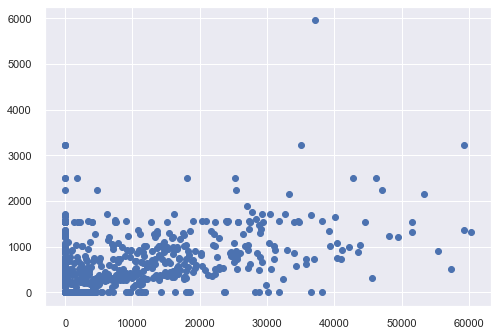

In [1346]:
X_[["Population", "CovidByPopulation"]]

plt.scatter(X["Population"], X["CovidRate"])

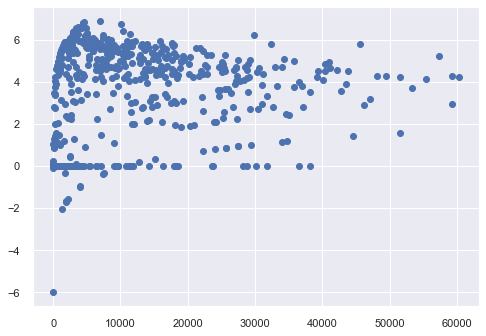

In [1350]:
plt.scatter(X_["Population"], X_["CovidByPopulationLog"])
plt.show()

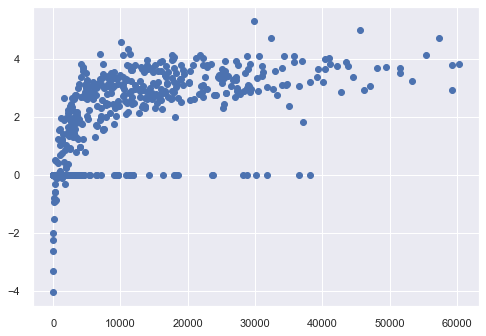

In [1351]:
plt.scatter(X_["Population"], X_["CovidRateByPopulationLog"])
plt.show()

### According to plots it seems easier to predict CovidRateByPopulationLog normilizaed variable. It seems like it has the greatest correlation.

# Prediction

### Model Selection

In [1402]:
from sklearn.model_selection import train_test_split

features = list(filter(lambda x: x not in ["ZipCode", "OldCity", "County", "CovidByPopulation", "CovidRate", "CovidCount", "City"], FEATURES))

y = X_["CovidByPopulationLog"]
y_rate = X_["CovidRateByPopulationLog"]
X_f = X_[features]
X_train, X_test, y_train, y_test = train_test_split(X_f, y, train_size=0.87)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_f, y_rate, train_size=0.87)

In [1180]:
from sklearn.model_selection import cross_validate

def evaluate_learners(models, X, y):
    cross_validations = [cross_validate(model, X, y, return_train_score=True,) for model in models]
    return (
        list(map(lambda x: x["train_score"], cross_validations)),
        list(map(lambda x: x["test_score"], cross_validations))
    )

In [1403]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR


models = [LinearRegression(), Ridge(), Lasso(), RandomForestRegressor(), AdaBoostRegressor(), LinearSVR()]
train_scores, test_scores = evaluate_learners(models, X_train, y_train)
train_scores_r, test_scores_r = evaluate_learners(models, X_train_r, y_train_r)

In [1404]:
[print(ts.mean()) for ts in train_scores];

0.38178407099171646
0.3456702119680539
0.20930939065753684
0.9350628938450032
0.6909793092346453
-12986.753438883565


In [1405]:
[print(ts.mean()) for ts in train_scores_r];

0.5702665004205689
0.5570662421008356
0.5085463374123564
0.950230013586031
0.7980053174312048
-6.590433145935808


In [1406]:
[print(ts.mean()) for ts in test_scores];

0.3143225041068602
0.28891379995735705
0.16355144885499903
0.612480949742301
0.5732680102760145
-12419.00868926537


In [1407]:
[print(ts.mean()) for ts in test_scores_r];

0.5274863052557883
0.5226710847318569
0.4832914685420153
0.7219456855816239
0.6864938639569406
-6.4799386814869075


### In comparisong over different models and target variables Random Forest showed the best scores: 94 train score and 67 test. And model evaluations also showed that log of rate by population is higher than log of cases by population

### Tuning parameters:

In [1421]:
from sklearn.model_selection import GridSearchCV

params_random_for = [
    {"n_estimators": np.arange(10, 60, dtype=int)},
    {"criterion": ["mse", "mae"]},
]

def tune_model(model_class, parameters, X_train, y_train):
    r = GridSearchCV(model_class(), parameters, return_train_score=True).fit(X_train, y_train)
    return r.best_score_, r.best_params_

tune_model(RandomForestRegressor, params_random_for, X_train_r, y_train_r)

(0.7504151525313302, {'n_estimators': 55})

### After Hyperparameter testing Random forest is evaluated with evaluated accuracy of 75%
### The best number for `n_estimators` parameter is betwen 27 and 37

### Cross-validating fine-tuned model:

In [1495]:
models = [RandomForestRegressor(n_estimators=33)]
_1, _2 = evaluate_learners(models, X_train_r, y_train_r)

In [1496]:
_1[0].mean()

0.9594411469951277

In [1497]:
_2[0].mean()

0.7395386509996523

### Cross-validation exposed a model accuracy around 74%

In [1504]:
rf = RandomForestRegressor(n_estimators=33)
rf.fit(X_train_r, y_train_r)
rf.score(X_test_r, y_test_r)

0.6293063720452741

In [1506]:
X_total = X_[features]
y_total = X_["CovidRateByPopulationLog"]

In [1507]:
preds = rf.predict(X_total)

In [1514]:
from sklearn.metrics import r2_score

r2_score(preds, y_total)

0.9106046329236596

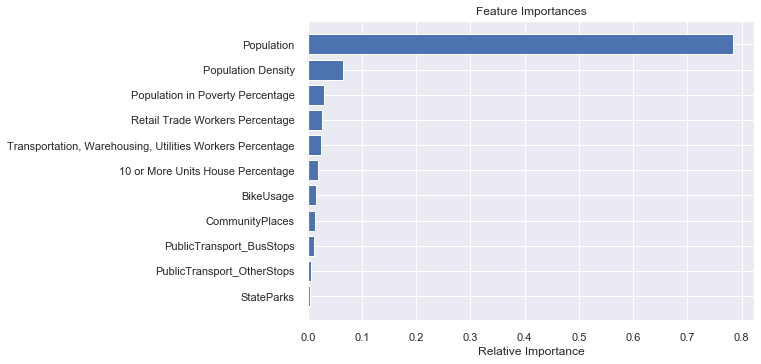

In [1511]:
features = X_total.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Unnormalize our values and count risk_index

In [1527]:
risk_scores = np.exp(preds)
risk_indexes = (risk_scores / risk_scores.max() * 100).astype(int)

In [1529]:
X_["risk_index_predicted"] = risk_indexes

In [1532]:
X_.sort_values(by="risk_index_predicted", ascending=False)

,ZipCode,City,OldCity,County,PublicTransport_BusStops,PublicTransport_OtherStops,CommunityPlaces,BikeUsage,HealthIndex,Population,...,Population in Poverty Percentage,10 or More Units House Percentage,StateParks,CovidCount,CovidRate,CovidByPopulation,CovidByPopulationLog,CovidRateByPopulation,CovidRateByPopulationLog,risk_index_predicted
94,1201,Pittsfield,Pittsfield,Berkshire,0.0,0.0,14,0.0,12,45557,...,0.160,0.099,1.0,138,311.67,330.123188,5.799466,146.170629,4.984775,100
538,2360,Plymouth,Plymouth,Plymouth,0.0,0.0,5,0.0,8,57275,...,0.068,0.051,3.0,317,510.99,180.678233,5.196718,112.086342,4.719269,71
390,2038,Franklin,Franklin,Norfolk,0.0,0.0,15,0.0,4,32393,...,0.038,0.117,1.0,98,289.84,330.540816,5.800730,111.761662,4.716369,58
58,1085,Westfield,Westfield,Hampden,0.0,0.0,12,0.0,14,41121,...,0.107,0.111,1.0,384,923.56,107.085938,4.673632,44.524449,3.796038,56
298,1810,Andover,Andover,Essex,0.0,0.0,12,0.0,7,34251,...,0.044,0.142,0.0,210,583.09,163.100000,5.094364,58.740503,4.073129,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,2305,Brockton,Brockton,Plymouth,0.0,0.0,0,0.0,8,0,...,0.000,0.000,0.0,3179,3235.70,0.000000,0.000000,0.000000,0.000000,0
329,1866,Pinehurst,Pinehurst,Middlesex,0.0,0.0,2,0.0,1,0,...,0.000,0.000,0.0,0,0.00,0.000000,0.000000,0.000000,0.000000,0
328,1865,Nutting Lake,Nutting Lake,Middlesex,0.0,0.0,1,0.0,1,0,...,0.000,0.000,0.0,0,0.00,0.000000,0.000000,0.000000,0.000000,0
512,2325,Bridgewater,Bridgewater,Plymouth,0.0,0.0,5,0.0,8,0,...,0.000,0.000,0.0,287,1008.90,0.000000,0.000000,0.000000,0.000000,0


In [1535]:
X_["ZipCode"] = X_["ZipCode"].map(lambda x: f"0{x}")

In [1536]:
X_

,ZipCode,City,OldCity,County,PublicTransport_BusStops,PublicTransport_OtherStops,CommunityPlaces,BikeUsage,HealthIndex,Population,...,Population in Poverty Percentage,10 or More Units House Percentage,StateParks,CovidCount,CovidRate,CovidByPopulation,CovidByPopulationLog,CovidRateByPopulation,CovidRateByPopulationLog,risk_index_predicted
0,01001,Agawam,Agawam,Hampden,0.0,0.0,7,0.0,14,17141,...,0.084,0.144,0.0,333,1164.20,51.474474,3.941086,14.723415,2.689439,15
1,01002,Amherst,Amherst,Hampshire,0.0,0.0,10,0.0,5,29844,...,0.320,0.233,1.0,60,148.16,497.400000,6.209395,201.430886,5.305446,21
2,01003,Amherst,Amherst,Hampshire,0.0,0.0,1,0.0,5,11062,...,0.013,0.250,0.0,60,148.16,184.366667,5.216927,74.662527,4.312978,34
3,01004,Amherst,Amherst,Hampshire,0.0,0.0,1,0.0,5,0,...,0.000,0.000,0.0,60,148.16,0.000000,0.000000,0.000000,0.000000,0
4,01005,Barre,Barre,Worcester,0.0,0.0,5,0.0,10,5113,...,0.045,0.044,0.0,42,755.70,121.738095,4.801872,6.765912,1.911897,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,02783,Taunton,Taunton,Bristol,0.0,0.0,13,0.0,13,0,...,0.000,0.000,0.0,690,1204.60,0.000000,0.000000,0.000000,0.000000,0
699,02790,Westport,Westport,Bristol,0.0,0.0,0,0.0,13,16142,...,0.033,0.016,0.0,54,324.44,298.925926,5.700196,49.753421,3.907079,35
700,02791,Westport,Westport Point,Bristol,0.0,0.0,3,0.0,13,127,...,0.000,0.000,1.0,54,324.44,2.351852,0.855203,0.391444,-0.937914,0
701,05501,Andover,Andover,Essex,0.0,0.0,0,0.0,7,0,...,0.000,0.000,0.0,210,583.09,0.000000,0.000000,0.000000,0.000000,0


In [1538]:
wrkng["ZipCode"] = wrkng["ZipCode"].map(lambda x: f"0{x}")

In [1540]:
working_2 = pd.merge(left=X_, right=wrkng, on="ZipCode")

In [1544]:
total_df = working_2[["city", "county", "zip_code","lat","long", "risk_index_predicted"]]

In [1545]:
total_df["risk_index"] = total_df["risk_index_predicted"]

In [1546]:
total_df.to_csv("")

,city,county,zip_code,lat,long,risk_index_predicted,risk_index
0,Agawam,Hampden,01001,-72.625892,42.062587,15,15
1,Amherst,Hampshire,01002,-72.462105,42.374922,21,21
2,Amherst,Hampshire,01003,-72.524791,42.391919,34,34
3,Barre,Worcester,01005,-72.106150,42.420174,6,6
4,Belchertown,Hampshire,01007,-72.400360,42.278750,20,20
...,...,...,...,...,...,...,...
532,Swansea,Bristol,02777,-71.212034,41.757031,23,23
533,Berkley,Bristol,02779,-71.075434,41.834911,10,10
534,Taunton,Bristol,02780,-71.119560,41.907552,37,37
535,Westport,Bristol,02790,-71.083236,41.599888,35,35


In [1548]:
with open("data_analysis/project_data/risk_index_2.json", "w+") as f:
    f.write(total_df.to_json())

In [1549]:
total_df

,city,county,zip_code,lat,long,risk_index_predicted,risk_index
0,Agawam,Hampden,01001,-72.625892,42.062587,15,15
1,Amherst,Hampshire,01002,-72.462105,42.374922,21,21
2,Amherst,Hampshire,01003,-72.524791,42.391919,34,34
3,Barre,Worcester,01005,-72.106150,42.420174,6,6
4,Belchertown,Hampshire,01007,-72.400360,42.278750,20,20
...,...,...,...,...,...,...,...
532,Swansea,Bristol,02777,-71.212034,41.757031,23,23
533,Berkley,Bristol,02779,-71.075434,41.834911,10,10
534,Taunton,Bristol,02780,-71.119560,41.907552,37,37
535,Westport,Bristol,02790,-71.083236,41.599888,35,35
